In [ ]:
import numpy as np
from numba import jit
import math
import random
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#http://nozdrenkov.github.io/2015/12/16/lab2.html
#https://nznano.blogspot.com/2017/11/molecular-dynamics-in-python.html
#https://github.com/Comp-science-engineering/Tutorials/tree/master/MolecularDynamics

# Константы

In [ ]:
#Epsilon = 8.85e-12
#m = 40e-3 # Масса аргона
#kB = 1.38e-23
#sigma = 3.54e-10

m = 1
kB = 1
Epsilon = 1
sigma = 1

two_sigma = sigma * 2.5 # Растояние на котором нет сил взаимодействия
r_size = sigma * 2.4 # Растояние между молекулами

# Функции

In [ ]:
def create_speed(colvo_mol, min , max, mass):
  #arrays = [np.random.randint(low = min, high = max, size=(size_cube, size_cube)) for _ in range(size_cube)]
  arrays = np.array([[random.randint(min, max), random.randint(min, max), random.randint(min, max)] for _ in range(colvo_mol)])
  return arrays - (sum(arrays.ravel() * mass))/colvo_mol

In [ ]:
def fill_boxes(num, dx): # dx - размер куба частицы также расстояние между частицами
  return  np.array([[i*dx+dx/2, j*dx+dx/2, k*dx+dx/2] for k in range(num) for j in range(num) for i in range(num)])

In [ ]:
def get_newSpeed(a, new_a, v, dt):
  return [ (v[i] + 0.5 * dt * (a[i] + new_a[i])) for i in range(len(new_a))]

def get_newPos(pos_m, new_a, new_v, dt):
  return [ (pos_m[i] + new_v[i] * dt + 0.5 * new_a[i] * dt * dt) for i in range(len(pos_m))]

def Calculate_Temperature(new_speed):
  avg_eng = np.average([ ((m * np.dot(i, i)) / 2) for i in new_speed])
  return avg_eng, (avg_eng * 2) / (6 * kB)

def to_list(arr):
  new_arr = []
  for i in arr:
    for j in i:
      for k in j:
        for p in k:
          new_arr.append(p)
  return new_arr

# Класс

In [ ]:
class MD():
  Speed_Max = 1 # Максимальная скорость молекул
  delta_t = 0.002 # Чем меньше шаг по времени, тем меньше вероятность у частиц получить лишнюю энергию, следовательно увеличиться кол-во шагов симуляции

  frames = 1000 # The amount of frames in the animation
  curr_frame = 0
  # Temp = []
  # En_K = []
  # Force = []


  def __init__(self, lk):
    self.Lk = lk # кол-во кубиков частиц на одной стороне рассматриваемого куба, Lk^3 - кол-во частив всего
    self.L = self.Lk * r_size # Сторона исследуемого обьема
    self.Ls = math.ceil(self.L / two_sigma) # Разбиение общего обьема на кубы размером 2.5 сигма для расчета взаимодействий между молекулами
    self.N = self.Lk**3 # Общее кол-во молекул

    self.small_box = fill_boxes(self.Lk, r_size) # Генерация молекул
    self.Pos_mol = self.big_boxs(two_sigma, self.small_box) # Растановка молекул по ячейкам куба, а также проверка на вылет
    self.Speed = create_speed(self.N, -self.Speed_Max, self.Speed_Max, m) # Векторная скорость молекул
    self.Boost = self.Speed.copy() * 0

    self.Arr_two_inter = [[0 for i in range(self.N)] for j in range(self.frames)]
    self.Counter_two_inter = [0 for i in range(self.frames)]
    self.Arr_tree_inter = [0 for i in range(self.frames)]
    self.Temp = []
    self.En_K = []
    self.Force = []

    # self.Arr_two_inter = [[0] * self.N] * self.frames
    # self.Arr_tree_inter = [0] * self.frames

  def big_boxs(self, dx, pos_arr):
    Arr = [[[[] for k in range(self.Ls)] for j in range(self.Ls)] for i in range(self.Ls)]
    for point in pos_arr:
      new_point = abs(point) % self.L
      pos = [ int(abs(p)//dx) for p in new_point ]
      Arr[pos[0]][pos[1]][pos[2]].append(new_point)
    return Arr

  def get_all(self, point, n_points, inter_indx):
    force = np.array([0.0,0.0,0.0])
    for p in n_points:
      r_len = np.sqrt(np.sum(np.square(np.abs(point - p))))

      if(r_len > sigma) and (r_len < two_sigma):
        sr = sigma/r_len
        u = 4 * Epsilon * ( (sr)**12 - (sr)**6 )
        force += u
      elif(r_len <= sigma):
        self.Arr_two_inter[self.curr_frame][inter_indx] += 1
        #two = two + 1
    return force

  def get_in(self, point, n_points, inter_indx):
    force = np.array([0.0,0.0,0.0])
    for p in n_points:
      if(np.array_equal(p, point) == False):
        r_len = np.sqrt(np.sum(np.square(np.abs(point - p))))

        if(r_len > sigma) and (r_len < two_sigma):
          sr = sigma/r_len
          u = 4 * Epsilon * ( (sr)**12 - (sr)**6 )
          force += u
        elif(r_len <= sigma):
          self.Arr_two_inter[self.curr_frame][inter_indx] += 1
          #two = two + 1
    return force

  def Compute_Forces(self):
    U = []
    curr_cell = 0
    for i in range(self.Ls):
      for j in range(self.Ls):
        for k in range(self.Ls):
          for point in self.Pos_mol[i][j][k]:
            Summa = []
            flag = {}
            for indx in [i, j, k]:
              flag[indx] = -1 if (indx == self.Ls-1) else 1


            Summa.append(self.get_in(point, self.Pos_mol[i][j][k], curr_cell)) # In cell
            for dK in [k-1,k,flag[k]*(k+1)]:
              Summa.append(self.get_all(point, self.Pos_mol[flag[i]*(i+1)][j][dK], curr_cell)) #right ####i
              Summa.append(self.get_all(point, self.Pos_mol[i-1][j][dK], curr_cell)) #left
              Summa.append(self.get_all(point, self.Pos_mol[i][flag[j]*(j+1)][dK], curr_cell)) #up    ####j
              Summa.append(self.get_all(point, self.Pos_mol[i][j-1][dK], curr_cell)) #down
              Summa.append(self.get_all(point, self.Pos_mol[i-1][flag[j]*(j+1)][dK], curr_cell)) # up left           #### i,j left
              Summa.append(self.get_all(point, self.Pos_mol[i-1][j-1][dK], curr_cell)) #down left
              Summa.append(self.get_all(point, self.Pos_mol[flag[i]*(i+1)][flag[j]*(j+1)][dK], curr_cell)) #up right #### i,j right
              Summa.append(self.get_all(point, self.Pos_mol[flag[i]*(i+1)][j-1][dK], curr_cell)) #down right
            Summa.append(self.get_all(point, self.Pos_mol[i][j][flag[k]*(k+1)], curr_cell))      ####k
            Summa.append(self.get_all(point, self.Pos_mol[i][j][k-1], curr_cell))

            if(np.sum(self.Arr_two_inter[self.curr_frame][curr_cell]) >= 1):
              self.Arr_two_inter[self.curr_frame][curr_cell] +=1

            sumiliym = np.sum(self.Arr_two_inter[self.curr_frame][curr_cell])
            if sumiliym == 2:
              self.Counter_two_inter[self.curr_frame] +=1
            elif(sumiliym == 3):
              self.Arr_tree_inter[self.curr_frame] +=1

            curr_cell += 1
            U.append(np.add.reduce(Summa))
    return U

  def calculate(self):
    while(self.curr_frame < self.frames):
      self.Force = self.Compute_Forces()
      # if(np.sum(self.Arr_two_inter[self.curr_frame]) > 1):
      #   break
      # print(np.sum(self.Arr_two_inter[self.curr_frame]), self.curr_frame)
      # #break
      newBoost = [p/m for p in self.Force]
      newSpeed = get_newSpeed(self.Boost, newBoost, self.Speed, self.delta_t)
      new_Pos_mol = get_newPos(to_list(self.Pos_mol), newBoost, newSpeed, self.delta_t)
      self.Pos_mol = self.big_boxs(two_sigma, new_Pos_mol)
      Ek, T = Calculate_Temperature(newSpeed)
      self.Temp.append(T)
      self.En_K.append(Ek)
      self.Speed = newSpeed.copy()
      self.Boost = newBoost.copy()
      self.curr_frame += 1

  def info(self):
    print('Максимальная скорость', np.sort(self.Speed, axis = 0)[1])
    print('Максимальная сила', np.sort(self.Force, axis = 0)[1])
    #print("Минимальное растояние", np.sort(R[frames - 1], axis = 1)[-1])
    print('Максимальное ускорение', np.sort(self.Boost, axis = 0)[1])

  def Plot(self):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle('Количество молекул = ' + str(self.N) + ", Обьем = " + str(self.L**3))
    axs[0,0].set_title('Temp')
    axs[0,1].set_title('En_K')
    axs[0,0].plot(self.Temp)
    axs[0,1].plot(self.En_K)

    axs[1,0].set_title('2')
    axs[1,1].set_title('3')
    axs[1,0].plot(self.Counter_two_inter)
    axs[1,1].plot(self.Arr_tree_inter)
    # axs[1,0].plot([ np.sum(elm) for elm in self.Arr_two_inter])
    # axs[1,1].plot([ elm for elm in self.Arr_tree_inter])

# Вычисления

## 2

In [ ]:
model = MD(2)

In [ ]:
#start_time = time.time()
model.calculate()
#print("--- %s seconds ---" % (time.time() - start_time))

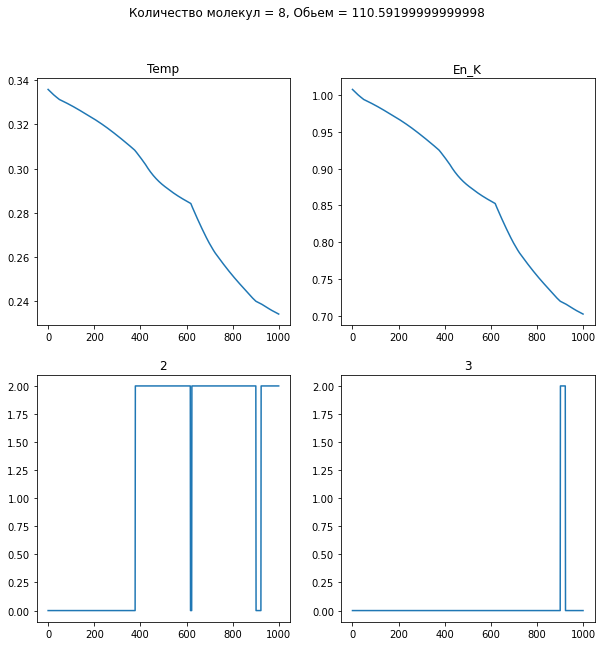

In [ ]:
model.Plot()

## 3

In [ ]:
model3 = MD(3)
model3.calculate()

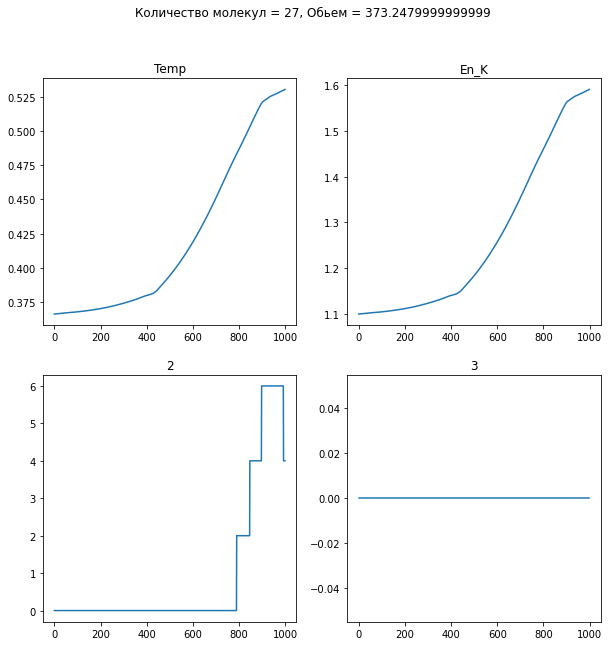

In [ ]:
model3.Plot()

## 4

In [ ]:
model4 = MD(4)
model4.calculate()

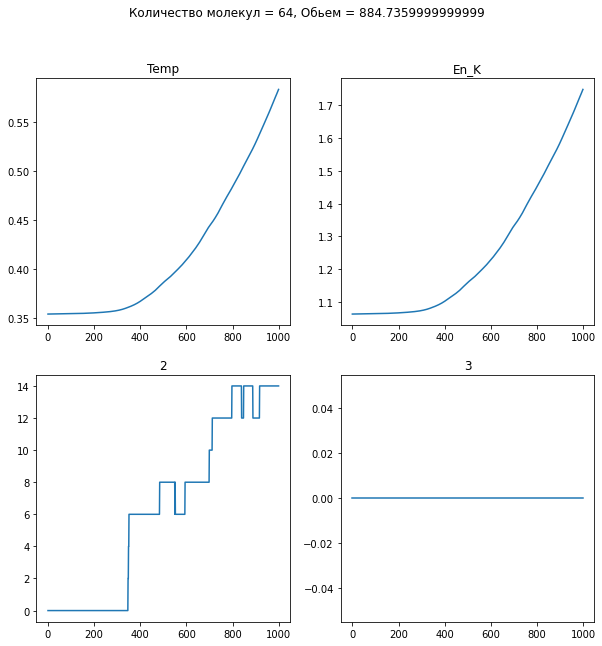

In [ ]:
model4.Plot()

## 5

In [ ]:
model5 = MD(5)
model5.calculate()

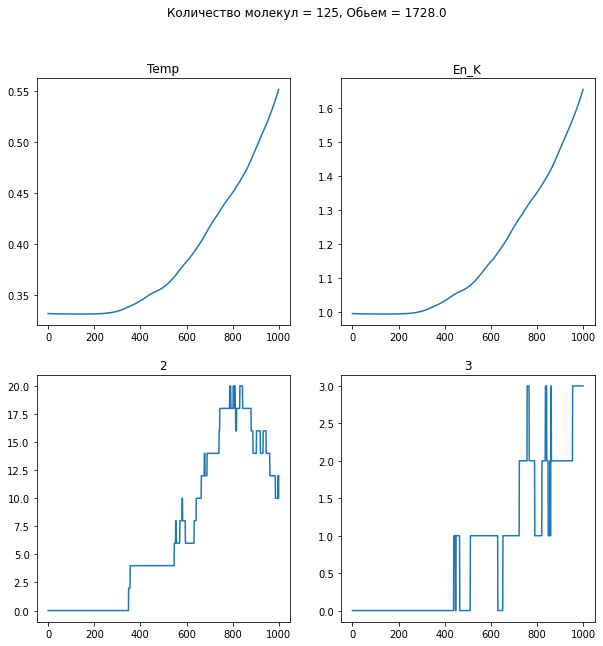

In [ ]:
model5.Plot()

## 6

In [ ]:
model6 = MD(6)
model6.calculate()

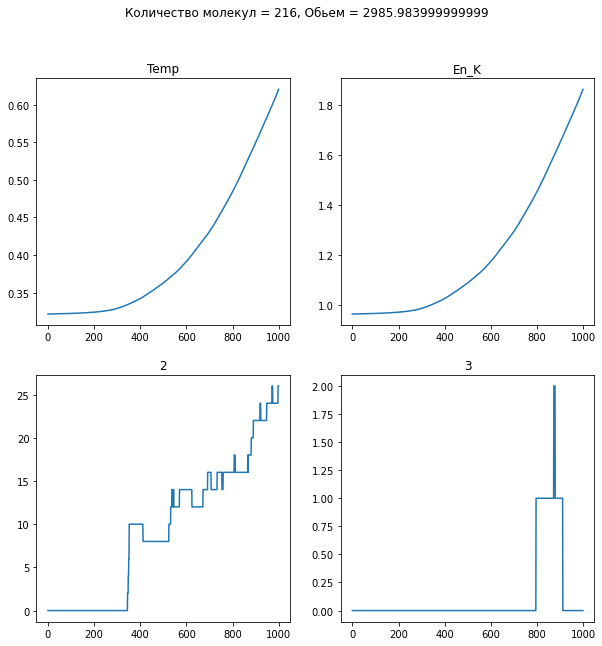

In [ ]:
model6.Plot()

## 7

In [ ]:
model7 = MD(7)
model7.calculate()

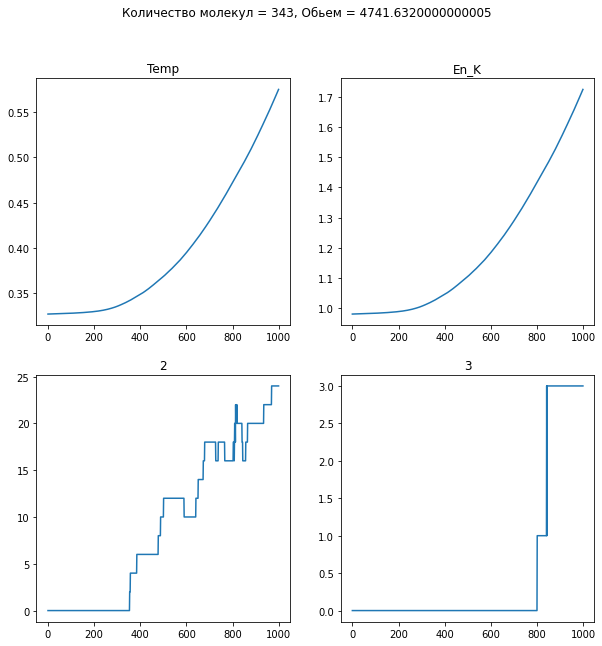

In [ ]:
model7.Plot()

## 8

In [ ]:
model8 = MD(8)
model8.calculate()

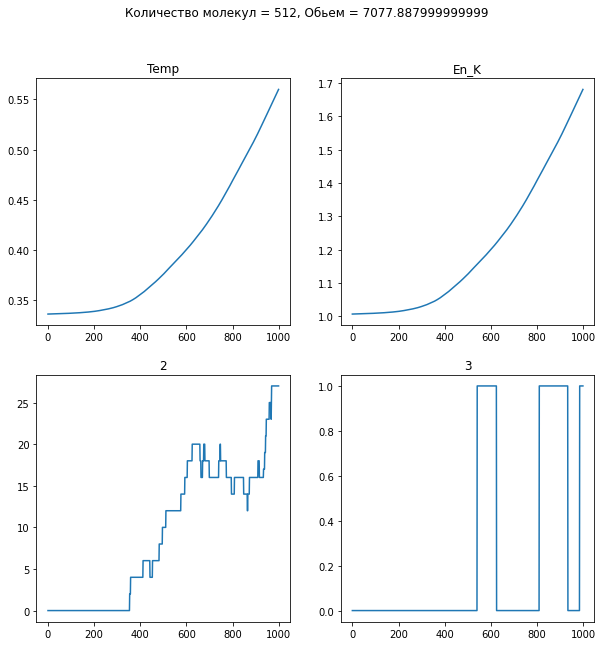

In [ ]:
model8.Plot()

## 9

In [ ]:
model9 = MD(9)
model9.calculate()

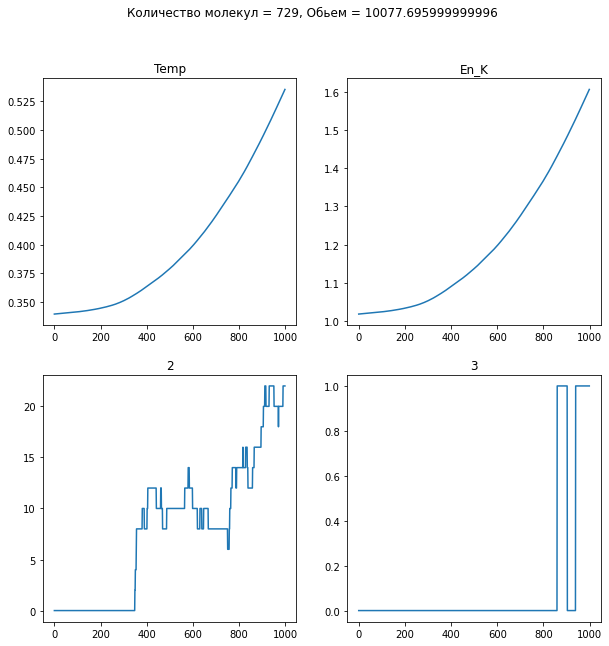

In [ ]:
model9.Plot()

## 10

In [ ]:
model10 = MD(10)
model10.calculate()

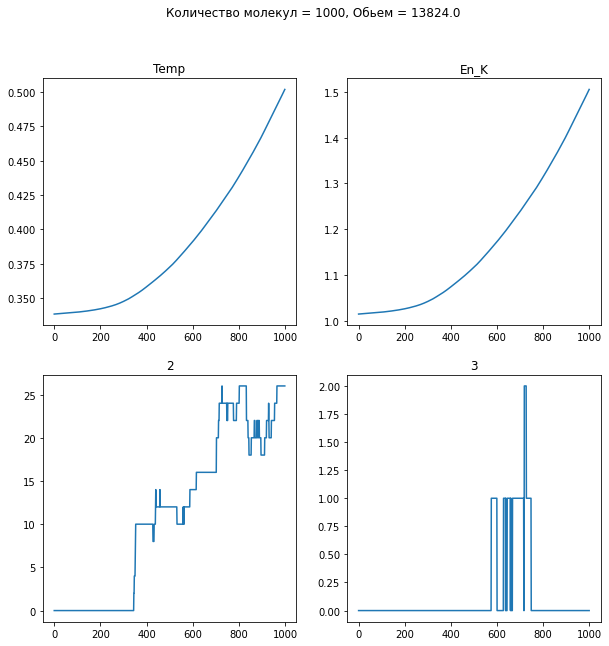

In [ ]:
model10.Plot()

# Сводка

In [ ]:
num_mol = []
two_inter = []
tree_inter = []
v_mol = []
for elm in [model, model3, model4, model5, model6, model7, model8, model9, model10]:
  num_mol.append(elm.N)
  two_inter.append(np.average(elm.Counter_two_inter))
  tree_inter.append(np.average(elm.Arr_tree_inter))
  # two_inter.append(np.max(elm.Counter_two_inter))
  # tree_inter.append(np.max(elm.Arr_tree_inter))
  v_mol.append(elm.L**3)

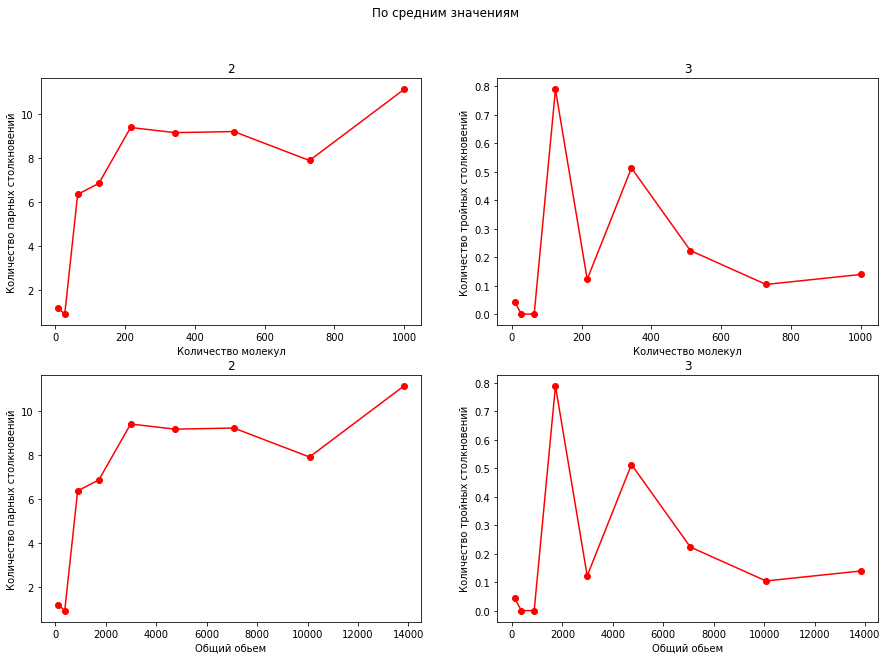

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('По средним значениям')
axs[0,0].set_title('2')
axs[0,1].set_title('3')
axs[0,0].plot(num_mol, two_inter, '-ro')
axs[0,1].plot(num_mol, tree_inter, '-ro')
axs[1,0].set_title('2')
axs[1,1].set_title('3')
axs[1,0].plot(v_mol, two_inter, '-ro')
axs[1,1].plot(v_mol, tree_inter, '-ro')
plt.setp(axs[0, :], xlabel = 'Количество молекул')
plt.setp(axs[1, :], xlabel = 'Общий обьем')
plt.setp(axs[:, 0], ylabel = 'Количество парных столкновений')
plt.setp(axs[:, 1], ylabel = 'Количество тройных столкновений')
plt.show()

In [ ]:
num_mol = []
two_inter = []
tree_inter = []
v_mol = []
for elm in [model, model3, model4, model5, model6, model7, model8, model9, model10]:
  num_mol.append(elm.N)
  two_inter.append(np.max(elm.Counter_two_inter))
  tree_inter.append(np.max(elm.Arr_tree_inter))
  v_mol.append(elm.L**3)

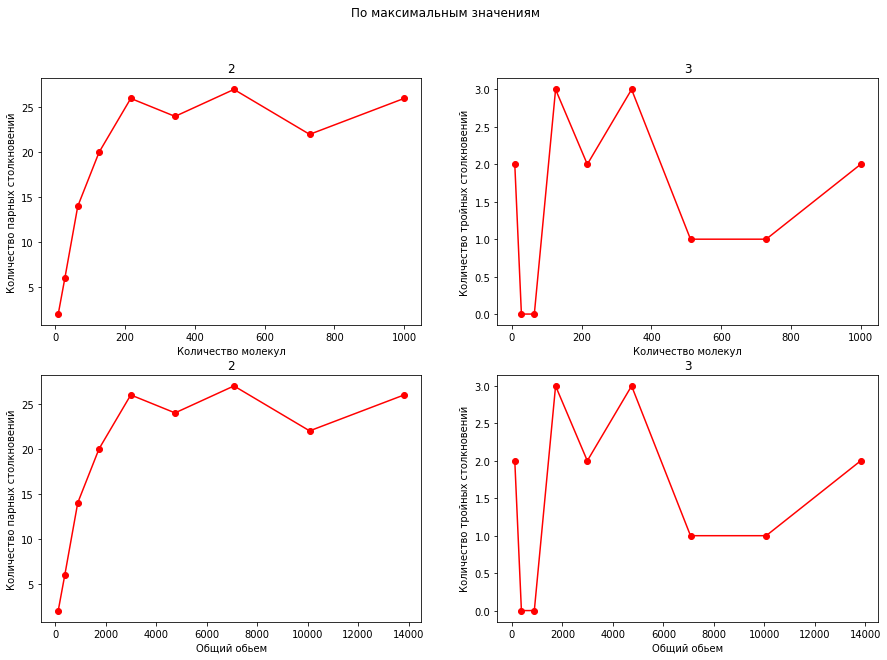

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('По максимальным значениям')
axs[0,0].set_title('2')
axs[0,1].set_title('3')
axs[0,0].plot(num_mol, two_inter, '-ro')
axs[0,1].plot(num_mol, tree_inter, '-ro')
axs[1,0].set_title('2')
axs[1,1].set_title('3')
axs[1,0].plot(v_mol, two_inter, '-ro')
axs[1,1].plot(v_mol, tree_inter, '-ro')
plt.setp(axs[0, :], xlabel = 'Количество молекул')
plt.setp(axs[1, :], xlabel = 'Общий обьем')
plt.setp(axs[:, 0], ylabel = 'Количество парных столкновений')
plt.setp(axs[:, 1], ylabel = 'Количество тройных столкновений')
plt.show()